<a href="https://colab.research.google.com/github/123ranika/jsfinal/blob/main/FacebookAI_xlm_roberta_base_run_6000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [98]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [99]:
!pip install transformers

## Importing necessary packages

In [100]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [101]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [102]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading training data

In [103]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_excel('/content/Dataset (3).xlsx')


In [104]:
data=data[:6000]

In [105]:
data.count()

,0
texts,6000
labels,6000


In [106]:
data.head()

,texts,labels
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [107]:
# Add an ID column starting from 1
data['PID'] = range(1, len(data) + 1)

In [108]:
data.head()

,texts,labels,PID
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,1
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,2
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,3
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred,4
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,5


In [109]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
data = change_column_name(data, old_name="label", new_name="labels")
data = change_column_name(data, old_name="Comments", new_name="text")
data.head() # Display the first few rows of the DataFrame
#text


# Move the ID column to the first position
cols = ['PID'] + [col for col in data.columns if col != 'PID']
data = data[cols]

data.head()

,PID,texts,labels
0,1,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,2,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,3,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,4,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,5,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [110]:


# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'texts', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 6,000

       PID                                              texts  \
1782  1783                                   হালি ঘুমায় কেমনে   
3917  3918                                        হাউন আঙ্কেল   
221    222               মমতাজের জন্য পার্লামেন্ট সর্গে উঠেছে   
2135  2136                             পাইপটা নিচে লাগিয়ে চুষ   
5224  5225  যদি দাড়ি টুপি আলাদের গালগাল খেতে চান তাহলে মু...   
1168  1169                           সস্তা মেয়েদের এভাবেই খায়   
879    880                 আর কইদিন পরে ওই ২টা বিচি হয়ে জাবে।   
156    157      কোনো কিছুতে লাগলে টেলেন্ট পুটকি দিয়া গেল অইলে   
1657  1658                         লিজেন্ড রা অন্য কিছু দেকবে   
323    324                               হালা টোকাইয়ের বংস ধর   

                labels  
1782     Cyberbullying  
3917           Sarcasm  
221            Sarcasm  
2135     Cyberbullying  
5224  Religious_Hatred  
1168     Cyberbullying  
879      Cyberbullying  
156      Cyberbullying  
1657           Sarcasm

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [112]:
train_df

,PID,texts,labels
3897,3898,মা কিভাবে পারেন তাকে নিয়ে ট্রল করতে,Cyberbullying
5628,5629,নায়িকা এত মোটা কেন,Racism
1756,1757,ধাক্কা ধাক্কি করবেন না,Cyberbullying
2346,2347,গরুর ভূড়ি ঠিকি তো পছন্দ করো তাহলে আমার এই ভূড়ি...,Cyberbullying
2996,2997,ভারতের কসাই,Cyberbullying
...,...,...,...
3772,3773,হাসিনাকে অতি শিগগিরী দেশে ফিরিয়ে এনে ২০০৯ এর ...,Political
5191,5192,এখন নাচতে শুরু করেছে পরে বাঁচতে শুরু করবে,Sarcasm
5226,5227,ইন্ডিয়ান লক্ষ লক্ষ পর্নো ভিডিও ইন্টারনেটে আপল...,Cyberbullying
5390,5391,পাগোল যদি মাঠে থাকে তাহলে বিবাহ হবেনানে,Sarcasm


In [113]:
test_df

,PID,texts,labels
5000,5001,নাচের সাথে ধর্মের কোনো কারণ নেই।,Religious_Hatred
5492,5493,নিজের গায়ে লাগলে হারাম অন্যের সময় হালাল,Religious_Hatred
439,440,পানি লে আগে নাহলি মাতা ঘুইরি পইরি জাবিন,Sarcasm
4834,4835,ভাস্কর খানকির ছেলে পাঠা,Cyberbullying
1225,1226,ড্রাইভার আবেদ আলী কাকু নাকি?,Sarcasm
...,...,...,...
1086,1087,হানিবানি ম্যাডাম ঠিক এই ভাবে কথা বলে,Cyberbullying
5488,5489,নামধারী আলেম শুধু লেগে থাকেন একজন আরেকজনের দোষ...,Religious_Hatred
776,777,পাগলা গারদে মোবাইল ইন্টারনেট ব্যাবহার করা যায় ...,Sarcasm
4190,4191,মাতারির বাড়ির লোকেশন দেন,Cyberbullying


In [114]:
val_df

,PID,texts,labels
5160,5161,কভু আশীবিষে দংশেনি যারে।,Sarcasm
2845,2846,মাথায় কি এতো ঝামেলা সয়-?,Sarcasm
1870,1871,খালি কলস বেশি বাজে,Sarcasm
3606,3607,বউ ও নাই নেট ও নাই,Sarcasm
1074,1075,মিয়া মিয়া লাগে,Cyberbullying
...,...,...,...
426,427,তানিশা বারো বাতারি,Cyberbullying
2864,2865,এবার কাকুর ফলক উন্মোচন হবে!,Sarcasm
1501,1502,পুটকি মারতে মারতে মাইরা লাইবার মনে ক,Cyberbullying
4915,4916,সৌদি দের পা ধুয়া পানি খা,Religious_Hatred


In [115]:
train_df['labels'].value_counts()

,count
labels,
Cyberbullying,1695
Sarcasm,1606
Political,788
Religious_Hatred,469
Racism,194
Gender_Discrimination,48


In [116]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [117]:
train_df['labels'].value_counts()

,count
labels,
0,1695
5,1606
2,788
4,469
3,194
1,48


### Loading `train_sentences` and `train_labels`

In [118]:
# Get the lists of sentences and their labels.
train_sentences = train_df['texts'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [119]:
data.labels.unique()

array(['Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'], dtype=object)

In [120]:
class_names = [
            'Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'
]

## Loading the validation data

In [121]:
val_df['labels'] = le.transform(val_df['labels'])

In [122]:

val_df['labels'].value_counts()

,count
labels,
0,216
5,191
2,104
4,54
3,30
1,5


### Loading `val_sentences` and `val_labels`

In [123]:
# Get the lists of sentences and their labels.
val_sentences = val_df['texts'].values
val_labels = val_df['labels'].values

In [124]:
val_labels

array([5, 5, 5, 5, 0, 0, 3, 0, 5, 3, 2, 4, 0, 0, 0, 5, 0, 0, 0, 0, 4, 4,
       0, 4, 0, 0, 0, 5, 5, 5, 3, 5, 0, 0, 0, 5, 0, 2, 3, 5, 4, 2, 4, 5,
       5, 5, 0, 5, 2, 2, 0, 5, 3, 2, 0, 5, 5, 0, 4, 2, 2, 2, 4, 0, 2, 4,
       0, 0, 5, 3, 0, 0, 2, 0, 5, 3, 4, 5, 4, 4, 3, 5, 0, 5, 0, 0, 3, 2,
       2, 5, 3, 5, 4, 2, 0, 0, 0, 2, 4, 5, 0, 5, 5, 0, 0, 5, 5, 4, 2, 0,
       5, 2, 5, 0, 3, 2, 5, 0, 5, 5, 5, 4, 2, 5, 0, 0, 5, 5, 0, 5, 2, 0,
       3, 5, 2, 0, 0, 0, 2, 0, 5, 0, 3, 2, 0, 0, 2, 2, 0, 2, 0, 4, 0, 0,
       2, 0, 1, 5, 0, 2, 4, 3, 0, 5, 4, 4, 0, 0, 5, 4, 5, 4, 5, 5, 5, 2,
       5, 2, 3, 5, 0, 0, 5, 2, 4, 0, 0, 5, 5, 2, 4, 0, 0, 0, 0, 5, 0, 4,
       5, 5, 0, 0, 0, 0, 5, 2, 5, 0, 0, 0, 0, 5, 4, 2, 5, 5, 5, 0, 5, 5,
       0, 4, 0, 0, 5, 4, 5, 4, 0, 0, 5, 0, 0, 5, 5, 5, 0, 2, 5, 0, 0, 0,
       5, 4, 0, 0, 5, 0, 5, 5, 5, 0, 5, 0, 1, 4, 0, 2, 3, 0, 5, 5, 5, 5,
       0, 0, 4, 2, 5, 3, 0, 5, 0, 2, 0, 0, 3, 2, 4, 5, 5, 0, 0, 0, 2, 0,
       5, 5, 2, 5, 5, 2, 5, 5, 2, 0, 0, 0, 0, 5, 5,

## Helper Functions

#### 1) Update Interval Function

In [125]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [126]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [127]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [128]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [129]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [130]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [131]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [132]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                           #  token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [133]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [134]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [135]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [136]:
#model_name = 'sagorsarker/bangla-bert-base'

#model_name = 'google-bert/bert-base-multilingual-cased'

#model_name = 'distilbert/distilbert-base-uncased'

model_name = 'FacebookAI/xlm-roberta-base'

#
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading FacebookAI/xlm-roberta-base tokenizer...


In [137]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

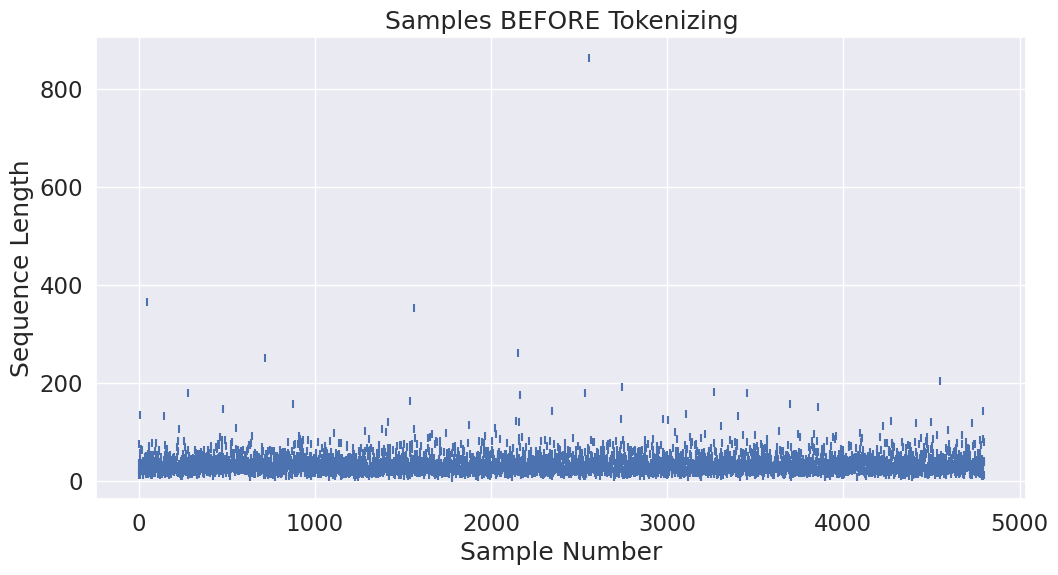

In [138]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [139]:
max_input_length = 300

In [140]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 4,800 training samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
DONE.
     4,800 samples


In [141]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

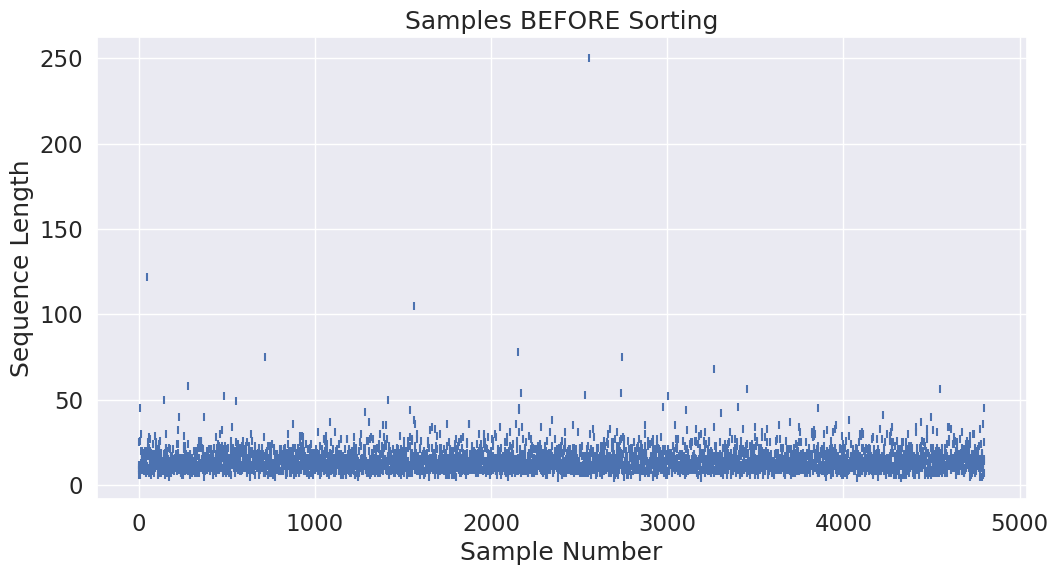

In [142]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [143]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [144]:
train_samples[0:5]

[([0, 240897, 223551, 2], 0),
 ([0, 127205, 9591, 2], 5),
 ([0, 127205, 47193, 2], 5),
 ([0, 190186, 47193, 2], 0),
 ([0, 128474, 176570, 2], 5)]

In [145]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 4
Longest sample: 250


In [146]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

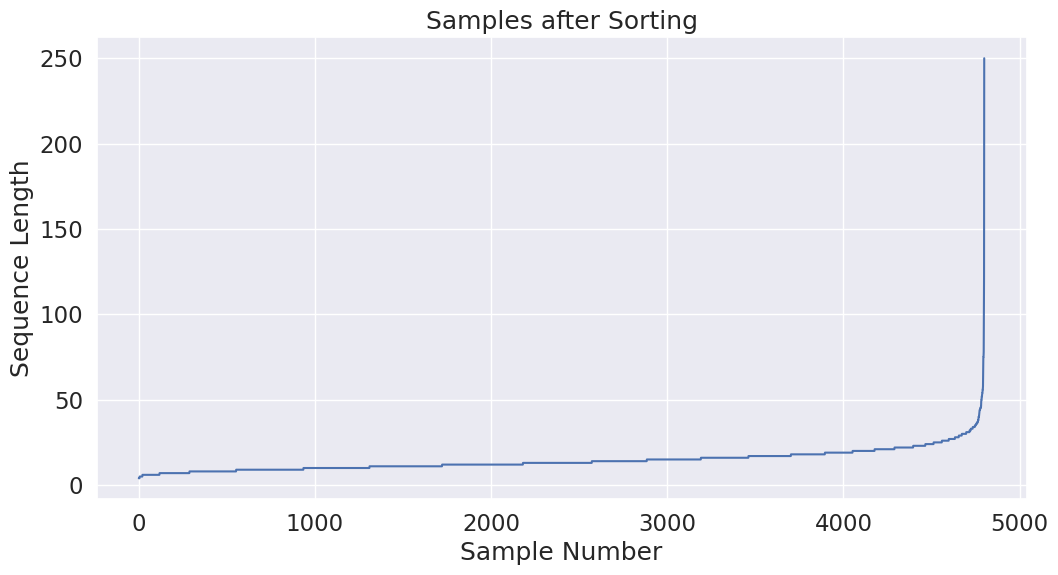

In [147]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [148]:
train_samples[0]

([0, 240897, 223551, 2], 0)

In [149]:
batch_size = 16

In [150]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.

  DONE - 300 batches.


In [151]:
print(batch_ordered_sentences[0])

[[0, 14403, 37555, 16576, 7443, 4822, 4577, 5534, 2], [0, 44201, 9853, 2937, 50395, 2763, 16908, 53718, 2], [0, 13705, 2763, 4198, 14403, 27372, 75880, 23878, 2], [0, 6386, 8619, 2730, 21145, 26596, 8751, 189198, 2], [0, 21145, 30414, 9853, 3397, 21145, 85921, 122699, 2], [0, 6386, 7802, 2763, 140102, 4876, 176363, 4480, 2], [0, 6, 152860, 47458, 17145, 2801, 7163, 15709, 2], [0, 22540, 42854, 64963, 11622, 132526, 50442, 2801, 2], [0, 14536, 176569, 145895, 48940, 896, 18336, 89783, 2], [0, 240028, 209979, 24090, 7277, 23703, 2763, 5534, 2], [0, 6, 196776, 17145, 999, 4198, 214112, 125, 2], [0, 31527, 20423, 7802, 5534, 6, 57158, 2730, 2], [0, 168969, 47857, 53718, 117465, 91129, 8050, 5534, 2], [0, 44201, 5534, 58041, 20134, 9115, 9755, 16550, 2], [0, 37555, 11622, 71896, 44056, 125141, 14940, 67026, 2], [0, 67026, 9618, 2730, 45409, 8751, 80936, 956, 2]]


In [152]:
batch_ordered_labels[0]

[0, 5, 5, 5, 2, 0, 0, 5, 5, 5, 5, 5, 5, 3, 5, 0]

### Padding

In [153]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [154]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 1,440,000
  Smart Batching: 75,840  (94.7% less)


## Load the model configuration from the transformers library using AutoConfig

In [155]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'> 



In [156]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [157]:
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

## Load the model from the transformers library using AutoModel

In [158]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaModel'>


In [159]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [160]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [161]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [162]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [163]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [164]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 20

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [165]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [166]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        #output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    # (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size,  max_input_length)
    # val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 20 ========
Training on 300 batches...
  Batch      30 of     300. Elapsed: 0:00:05. Remaining: 0:00:42
  Batch      60 of     300. Elapsed: 0:00:10. Remaining: 0:00:41
  Batch      90 of     300. Elapsed: 0:00:15. Remaining: 0:00:35
  Batch     120 of     300. Elapsed: 0:00:20. Remaining: 0:00:30
  Batch     150 of     300. Elapsed: 0:00:25. Remaining: 0:00:25
  Batch     180 of     300. Elapsed: 0:00:30. Remaining: 0:00:20
  Batch     210 of     300. Elapsed: 0:00:34. Remaining: 0:00:14
  Batch     240 of     300. Elapsed: 0:00:38. Remaining: 0:00:09
  Batch     270 of     300. Elapsed: 0:00:42. Remaining: 0:00:05
  Average training loss: 1.26
  Training Accuracy: 0.47
  Training epoch took: 0:00:47
Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Token

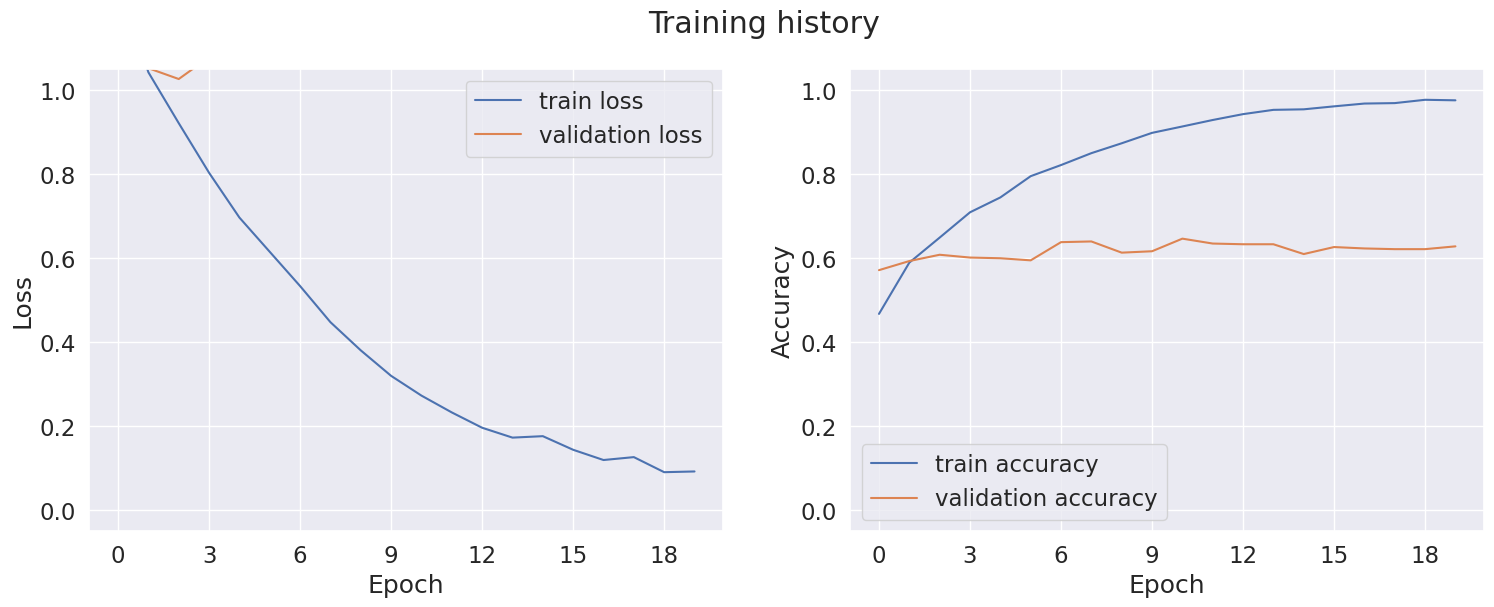

In [167]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [168]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 4,800 examples with batch size 16...

Tokenizing 4,800 samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
DONE.
     4,800 samples

     4,800 samples after sorting

Creating batches of size 16...

  DONE - Selected 300 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 300 test batches...
  Batch      30  of      300.    Elapsed: 0:00:01.  Remaining: 0:00:05
  Batch      60  of      300.    Elapsed: 0:00:01.  Remaining: 0:00:04
  Batch      90  of      300.    Elapsed: 0:00:01.  Remaining: 0:00:03
  Batch     120  of      300.    Elapsed: 0:00:02.  Remaining: 0:00:03
  Batch     150  of      300.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch     180  of      300.    Elapsed: 0:00:03.  Remaining: 0:00:02

In [169]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.99      1.00      0.99      1695
     Religious_Hatred       0.98      0.92      0.95        48
Gender_Discrimination       1.00      0.99      0.99       788
              Sarcasm       0.98      0.97      0.98       194
            Political       1.00      0.99      0.99       469
               Racism       0.99      1.00      0.99      1606

             accuracy                           0.99      4800
            macro avg       0.99      0.98      0.98      4800
         weighted avg       0.99      0.99      0.99      4800



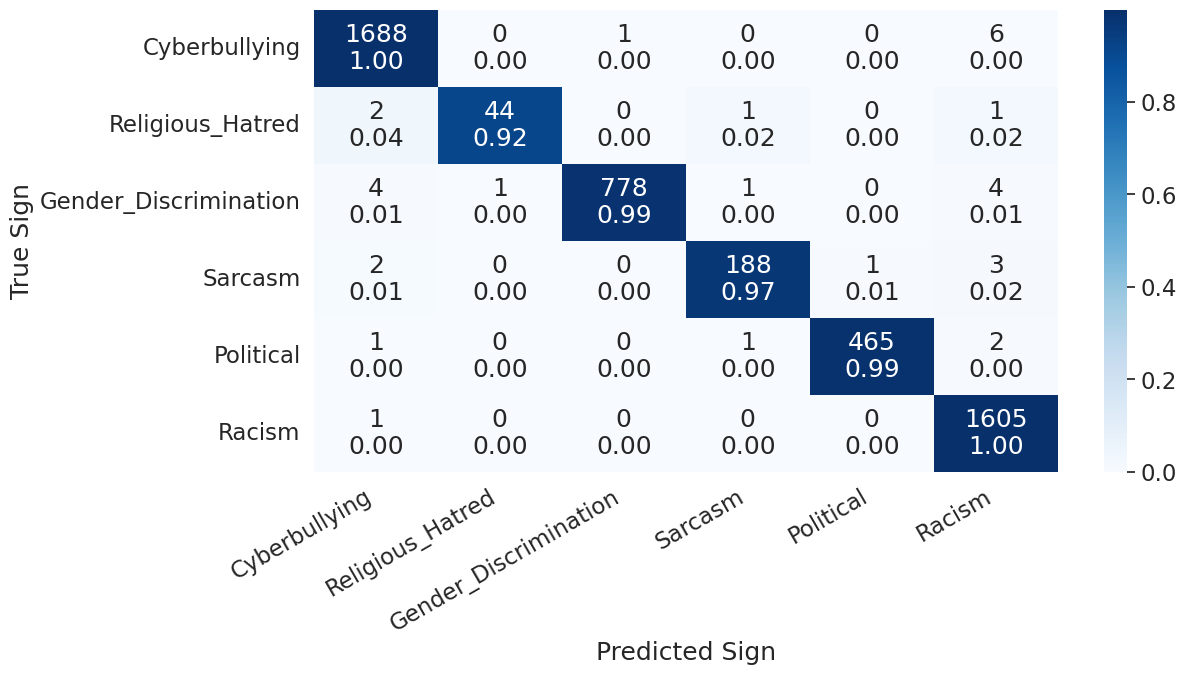

In [170]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [171]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       600 samples

       600 samples after sorting

Creating batches of size 16...

  DONE - Selected 38 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of   

In [172]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.63      0.65      0.64       216
     Religious_Hatred       0.67      0.40      0.50         5
Gender_Discrimination       0.74      0.70      0.72       104
              Sarcasm       0.39      0.40      0.39        30
            Political       0.70      0.65      0.67        54
               Racism       0.59      0.60      0.59       191

             accuracy                           0.63       600
            macro avg       0.62      0.57      0.59       600
         weighted avg       0.63      0.63      0.63       600



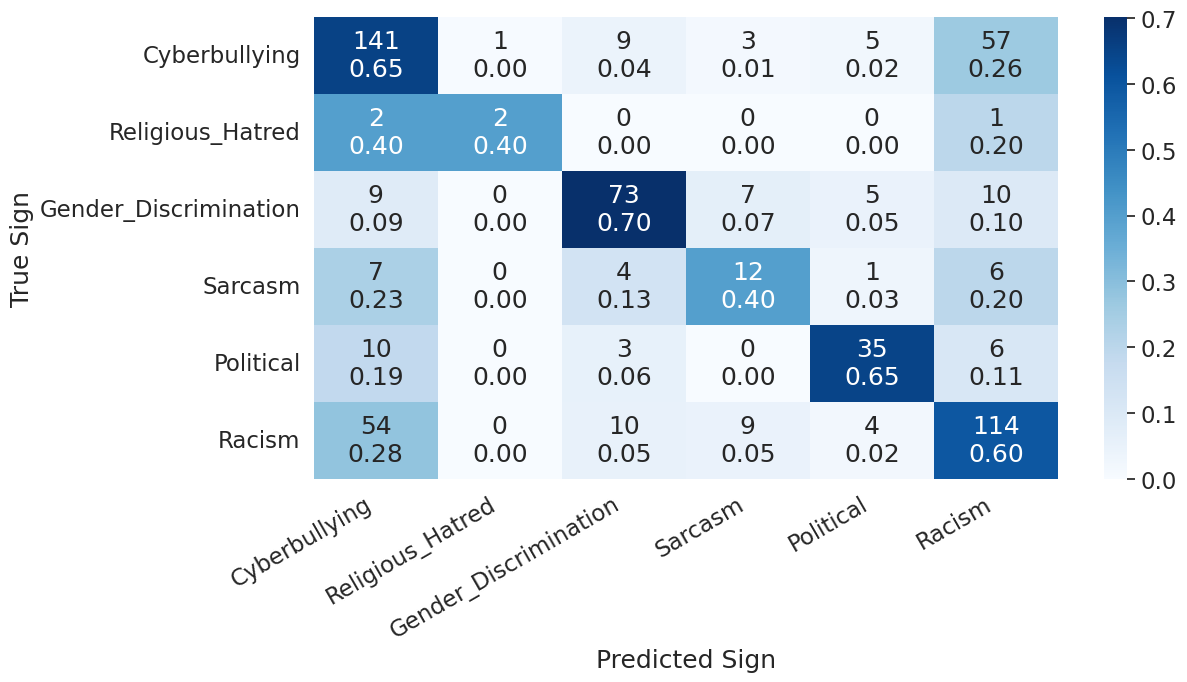

In [173]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [174]:
test_df

,PID,texts,labels
5000,5001,নাচের সাথে ধর্মের কোনো কারণ নেই।,Religious_Hatred
5492,5493,নিজের গায়ে লাগলে হারাম অন্যের সময় হালাল,Religious_Hatred
439,440,পানি লে আগে নাহলি মাতা ঘুইরি পইরি জাবিন,Sarcasm
4834,4835,ভাস্কর খানকির ছেলে পাঠা,Cyberbullying
1225,1226,ড্রাইভার আবেদ আলী কাকু নাকি?,Sarcasm
...,...,...,...
1086,1087,হানিবানি ম্যাডাম ঠিক এই ভাবে কথা বলে,Cyberbullying
5488,5489,নামধারী আলেম শুধু লেগে থাকেন একজন আরেকজনের দোষ...,Religious_Hatred
776,777,পাগলা গারদে মোবাইল ইন্টারনেট ব্যাবহার করা যায় ...,Sarcasm
4190,4191,মাতারির বাড়ির লোকেশন দেন,Cyberbullying


## Loading `test_sentences`

In [175]:
test_sentences = test_df['texts'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [176]:
test_ids

array([5000, 5492,  439, 4834, 1225,  183,  681, 4480, 2244,  381, 4879,
       2031, 4071, 3053, 5992, 3193, 5563, 5294, 4999, 3647, 1964, 3958,
       4369, 4866, 1176,  351, 2080, 5050, 1671,  622, 3867,  292, 3185,
       4724, 4557, 3184, 2977,  996, 1194,  445, 4762, 1039, 5317, 5368,
       5693, 1891, 5112, 3720, 3035, 1487, 4301, 4458,   69, 2892, 5510,
       2127,  199, 2357, 3469, 4939, 1864, 1535, 4756,  319,  549, 5118,
       5591, 2024, 5823, 5606, 5892, 1505, 3033, 4674, 3544,  245, 1978,
       4046, 2617, 5851,  748,  476, 1564,  124, 5527, 2834, 3484, 3090,
       4020, 3892, 4568, 2313, 1905, 4196,   93, 3459, 2602, 1161, 2788,
       5098,  371, 2163,  185, 5047, 2611, 3094, 2086, 4010,  228,  296,
       1407, 2476, 4310,  584, 2584,  752, 4353, 5846, 5525, 1817, 2957,
       3045, 5297, 2142, 1729, 1374, 2638, 1533, 3971, 4581, 3407, 3937,
       5556, 5808,   23, 3859, 3707, 5217, 3764, 4379, 3130, 4876, 3226,
        501, 2767, 3734, 4603, 5026, 2663, 5683,  3

In [177]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       600 samples

       600 samples after sorting

Creating batches of size 16...

  DONE - Selected 38 batches.

Padding out sequences within each batch...
  DONE.


In [178]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      32  of       38.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      36  of       38.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [179]:
test_sentences

array(['নাচের সাথে ধর্মের কোনো কারণ নেই।',
       'নিজের গায়ে লাগলে হারাম অন্যের সময় হালাল',
       'পানি লে আগে নাহলি মাতা ঘুইরি পইরি জাবিন',
       'ভাস্কর খানকির ছেলে পাঠা', 'ড্রাইভার আবেদ আলী কাকু নাকি?',
       'শালার পুত অহংকারী ওর পতন এমনিই হবে ইনশাআল্লাহ।',
       'তুমি তো সিয়াগো চেয়ে খারাপ', 'বেরোনা মোনা নাহলে ঘটি বেকিয়ে দেবো',
       'বুলেটের মুখে দাঁড়িয়েও বাঙালি',
       'বাংলায় একটা প্রবাদ আছে, রতনে রতন চিনে, আর শুকরে চিনে কচু। আর বেশি কিছু বললাম না।',
       'তৃণমূল এর পাকা পাঁঠা ঐ শালার গুলি করে মারা উচিত',
       'বাকি কাপড়টুকু না রাখলে আসল জিনিস দেখা যেত',
       'আরে এটা কে? কেত্থেকে এল এ? আর এর মুখ এত ছোট কেন? ',
       'খুনিরা করছে শোক।❞',
       'দেশে নিরপেক্ষ নির্বাচন হলে নিঃসন্দেহে আওয়ামীলীগ জয় লাভ করবে।',
       'একটু বুকে আই', 'যু্দ্ধ করবো ভারতের বিরুদ্ধে',
       'মিথ্যা নাটক এবার বন্দ কর অতিরিক্ত কোন কিছুই ভালো না',
       'র্খদের মতো এখনো মানুষকে লিঙ্গ,জাত,ধর্ম,কালো,সাদা হিসেবে বিবেচনা করি',
       'বিবেকটাই আসল।', 'ওরা সমাজটা নষ্ট করে দিচ্ছে',
       'এই ত

In [180]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 600 examples with batch size 16...

Tokenizing 600 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
DONE.
       600 samples

       600 samples after sorting

Creating batches of size 16...

  DONE - Selected 38 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of   

In [181]:
y_pred

array([0, 0, 0, 5, 5, 0, 0, 5, 2, 4, 5, 5, 5, 0, 0, 0, 0, 2, 5, 5, 2, 5,
       4, 0, 4, 5, 4, 5, 0, 5, 3, 4, 5, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
       4, 5, 0, 0, 0, 4, 2, 4, 0, 0, 2, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5,
       5, 5, 0, 2, 0, 5, 0, 5, 5, 5, 0, 2, 2, 0, 4, 5, 4, 4, 0, 3, 0, 0,
       5, 5, 0, 0, 2, 5, 0, 0, 0, 0, 5, 5, 2, 5, 0, 2, 0, 2, 0, 2, 5, 5,
       0, 0, 5, 5, 5, 3, 5, 5, 0, 2, 3, 4, 5, 0, 0, 4, 0, 5, 0, 0, 5, 5,
       4, 5, 5, 5, 5, 5, 5, 0, 3, 4, 0, 5, 5, 4, 5, 0, 4, 0, 0, 0, 0, 5,
       0, 3, 0, 5, 4, 0, 0, 5, 5, 2, 5, 5, 5, 0, 5, 5, 0, 5, 5, 5, 3, 5,
       2, 0, 3, 0, 0, 2, 4, 0, 2, 2, 5, 0, 0, 4, 5, 0, 0, 0, 2, 5, 4, 0,
       4, 5, 0, 0, 0, 0, 0, 5, 2, 2, 0, 0, 4, 0, 5, 0, 0, 5, 5, 0, 5, 0,
       0, 3, 0, 0, 5, 5, 2, 5, 0, 0, 5, 5, 5, 3, 2, 5, 2, 5, 5, 5, 5, 5,
       1, 5, 4, 3, 0, 3, 5, 0, 5, 0, 0, 3, 0, 2, 5, 5, 5, 5, 0, 0, 0, 5,
       0, 5, 5, 5, 0, 5, 1, 3, 0, 5, 0, 0, 0, 2, 5, 0, 0, 2, 2, 4, 5, 0,
       0, 0, 0, 4, 4, 5, 0, 4, 0, 0, 5, 4, 5, 2, 0,

## Evaluating accuracy over test set

In [182]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 38 test batches...
  Batch       4  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      28  of       38.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      32  of       38.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      36  of       38.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [183]:
print(y_preds)

[0 0 0 5 5 0 0 5 2 4 5 5 5 0 0 0 0 2 5 5 2 5 4 0 4 5 4 5 0 5 3 4 5 0 0 0 1
 0 3 0 0 0 0 0 4 5 0 0 0 4 2 4 0 0 2 5 0 0 0 0 5 0 0 0 0 5 5 5 0 2 0 5 0 5
 5 5 0 2 2 0 4 5 4 4 0 3 0 0 5 5 0 0 2 5 0 0 0 0 5 5 2 5 0 2 0 2 0 2 5 5 0
 0 5 5 5 3 5 5 0 2 3 4 5 0 0 4 0 5 0 0 5 5 4 5 5 5 5 5 5 0 3 4 0 5 5 4 5 0
 4 0 0 0 0 5 0 3 0 5 4 0 0 5 5 2 5 5 5 0 5 5 0 5 5 5 3 5 2 0 3 0 0 2 4 0 2
 2 5 0 0 4 5 0 0 0 2 5 4 0 4 5 0 0 0 0 0 5 2 2 0 0 4 0 5 0 0 5 5 0 5 0 0 3
 0 0 5 5 2 5 0 0 5 5 5 3 2 5 2 5 5 5 5 5 1 5 4 3 0 3 5 0 5 0 0 3 0 2 5 5 5
 5 0 0 0 5 0 5 5 5 0 5 1 3 0 5 0 0 0 2 5 0 0 2 2 4 5 0 0 0 0 4 4 5 0 4 0 0
 5 4 5 2 0 0 2 4 2 5 0 5 5 5 0 0 4 5 0 5 5 0 5 5 0 0 5 0 2 5 5 5 5 3 0 5 3
 5 0 0 5 2 5 3 3 5 5 0 0 0 2 0 0 0 0 0 0 0 5 5 0 0 5 5 0 2 0 0 5 0 0 0 4 4
 4 2 0 5 0 2 5 2 0 0 0 5 2 5 5 5 3 2 0 0 0 0 5 4 3 5 3 5 5 0 0 5 3 5 0 5 0
 4 0 0 5 5 0 0 5 5 5 5 0 5 2 0 3 5 4 5 2 0 5 5 5 3 5 5 0 4 5 5 0 5 5 4 0 5
 2 2 0 0 0 3 0 0 0 5 0 0 0 5 0 0 2 4 0 0 3 5 0 0 4 0 2 5 5 0 0 0 0 3 5 5 0
 5 4 0 2 2 5 2 0 2 3 0 0 

In [184]:
print(y_ids)

[2819 1888 4250 2913 2858 2770  613  751 4562 5000 5317 4756 5591 1407
 2584 4353 1487 5892 4020 1905   93 3459 5846  501 5026 5683 5314 3869
 1881  230 5094 4184 3492 2168 1879  168 1559 4838 5272  655 1002 5261
 1322 4240 4280 1225 5294 2080 1837 1186 4098 4594  960 5544 3967 1536
 3651  486  443 5687 2370 3617 4945 1586  414 1630 3670  439 5112 3130
 1400 3182 5330 5692 3289  437 3796 3163 3135 2410  742 3396 5006  452
  100 1192  977 4343  227 3320 3667 1569 1612 2420 2018 4878 4264 2742
 1315  776 5118  124  239 4001  297 3856  805 3392  308  292 1039  393
 2313 5297 2638 2663 1451 1057 3077 2677 1042  794 3784 4607 4956 1188
 1024 4758 2767 4603 4808 3973 5164 1507 4526 3550 2812 1075 1163 1448
 2377 4686 1617 4269 1543   15 5351 1209 3413 2187 1871 1859 2439 3285
 3607 5799  812 1755  691 2900 1158 3700 3193 4369 3033 2163 3734 2463
 2002 2115 2775 2323 3525 5658 1438 2977 4541 4745 5110 5409  167 4655
  747 5751 3372 3240  896 1073  530 4832 2347 5790 5597   29 5322 5400
 5273 

In [185]:
le.inverse_transform(y_preds)

array(['Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Sarcasm',
       'Sarcasm', 'Cyberbullying', 'Cyberbullying', 'Sarcasm',
       'Political', 'Religious_Hatred', 'Sarcasm', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Cyberbullying',
       'Political', 'Sarcasm', 'Sarcasm', 'Political', 'Sarcasm',
       'Religious_Hatred', 'Cyberbullying', 'Religious_Hatred', 'Sarcasm',
       'Religious_Hatred', 'Sarcasm', 'Cyberbullying', 'Sarcasm',
       'Racism', 'Religious_Hatred', 'Sarcasm', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Gender_Discrimination',
       'Cyberbullying', 'Racism', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying',
       'Religious_Hatred', 'Sarcasm', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Religious_Hatred', 'Political',
       'Religious_Hatred', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Sarcasm', 'Cyberbullying', 'Cyberbullying', '

<Axes: xlabel='count'>

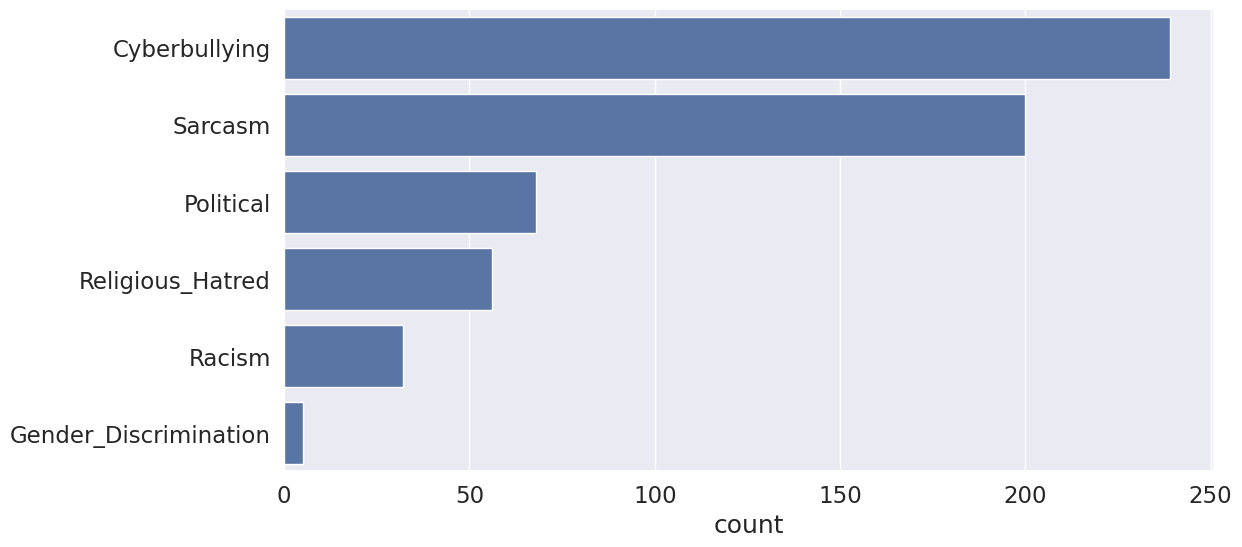

In [186]:
sns.countplot(y =le.inverse_transform(y_preds))

In [187]:
len(y_ids)

600

In [188]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Sarcasm',
       'Sarcasm', 'Cyberbullying', 'Cyberbullying', 'Sarcasm',
       'Political', 'Religious_Hatred', 'Sarcasm', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Cyberbullying',
       'Political', 'Sarcasm', 'Sarcasm', 'Political', 'Sarcasm',
       'Religious_Hatred', 'Cyberbullying', 'Religious_Hatred', 'Sarcasm',
       'Religious_Hatred', 'Sarcasm', 'Cyberbullying', 'Sarcasm',
       'Racism', 'Religious_Hatred', 'Sarcasm', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Gender_Discrimination',
       'Cyberbullying', 'Racism', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying',
       'Religious_Hatred', 'Sarcasm', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Religious_Hatred', 'Political',
       'Religious_Hatred', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Sarcasm', 'Cyberbullying', 'Cyberbullying', '